# Review and Learning Data Science on Bike Sharing Dataset from Kaggle
based on the notebook by Kaggle user at https://www.kaggle.com/code/adarshcgowda/bike-sharing-eda-and-demand-prediction

## Data Set Information

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental, and return has become automatic. Through these systems, a user can easily rent a bike from a particular position and return it at another position. There are about over 500 bike-sharing programs around the world which consist of over 500,000 bicycles. These systems are of great interest due to their role in traffic, environmental, and health issues.

The data generated by bike-sharing systems make them attractive for research. Unlike other transportation services such as buses or subways, the duration of travel, departure, and arrival position is explicitly recorded. This turns bike-sharing systems into a virtual sensor network that can be used for sensing mobility in the city. It is expected that most important events in the city could be detected by monitoring these data.

## Attribute Information

Both `hour.csv` and `day.csv` have the following fields, except `hr` which is not available in `day.csv`:

- `instant`: Record index
- `dteday`: Date
- `season`: Season (1: spring, 2: summer, 3: fall, 4: winter)
- `yr`: Year (0: 2011, 1:2012)
- `mnth`: Month (1 to 12)
- `hr`: Hour (0 to 23)
- `holiday`: Whether the day is a holiday or not (extracted from [Web Link])
- `weekday`: Day of the week
- `workingday`: If the day is neither weekend nor holiday is 1, otherwise it's 0.
- `weathersit`:
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: Normalized temperature in Celsius. The values are derived via \((t-t_{min})/(t_{max}-t_{min})\), \(t_{min}=-8\), \(t_{max}=+39\) (only in hourly scale)
- `atemp`: Normalized feeling temperature in Celsius. The values are derived via \((t-t_{min})/(t_{max}-t_{min})\), \(t_{min}=-16\), \(t_{max}=+50\) (only in hourly scale)
- `hum`: Normalized humidity. The values are divided by 100 (max)
- `windspeed`: Normalized wind speed. The values are divided by 67 (max)
- `casual`: Count of casual users
- `registered`: Count of registered users
- `cnt`: Count of total rental bikes including both casual and registered

For further information, please visit the following link: [Bike Sharing Dataset at UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)


In [1]:
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew, kurtosis

# statistical modelling
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# set the style of the plots
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# read data
df = pd.read_csv('Bike-Sharing-Dataset/hour.csv')
df.head().style.background_gradient(cmap='Greys')


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1


In [3]:
from tabulate import tabulate
import pandas as pd
from IPython.display import display, HTML

# Make sure to install tabulate if not already installed: !pip install tabulate

def data_overview(df, head=3):
    # General DataFrame overview
    print("DataFrame Overview".center(60, "="))
    
    # Shape of the DataFrame
    print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")
    
    # Missing values
    missing_values = df.isnull().sum()
    #missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    missing_values = missing_values.replace(0, '0')  # Replace 0 with '0' to ensure it displays correctly

    
    # Duplicated values
    duplicated_values = df.duplicated().sum()
    
    # Data types
    data_types = df.dtypes
    
    # Create a summary DataFrame
    overview_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Data Types': data_types
    })

    # Print the table using tabulate
    print(tabulate(overview_df, headers='keys', tablefmt='psql'))
    
    # Show the head of the DataFrame with HTML formatting
    display(HTML(df.head(head).to_html()))
    
    # Summary of duplicated entries
    print("Duplicated Entries:".center(60, "="))
    print(duplicated_values)

# Example usage:
data_overview(df)


=====================DataFrame Overview=====================
Rows: 17379 | Columns: 17
+------------+------------------+--------------+
|            |   Missing Values | Data Types   |
|------------+------------------+--------------|
| instant    |                0 | int64        |
| dteday     |                0 | object       |
| season     |                0 | int64        |
| yr         |                0 | int64        |
| mnth       |                0 | int64        |
| hr         |                0 | int64        |
| holiday    |                0 | int64        |
| weekday    |                0 | int64        |
| workingday |                0 | int64        |
| weathersit |                0 | int64        |
| temp       |                0 | float64      |
| atemp      |                0 | float64      |
| hum        |                0 | float64      |
| windspeed  |                0 | float64      |
| casual     |                0 | int64        |
| registered |                0

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


====================Duplicated Entries:=====================
0


Number of bins: 131


Text(0, 0.5, 'Frequency')

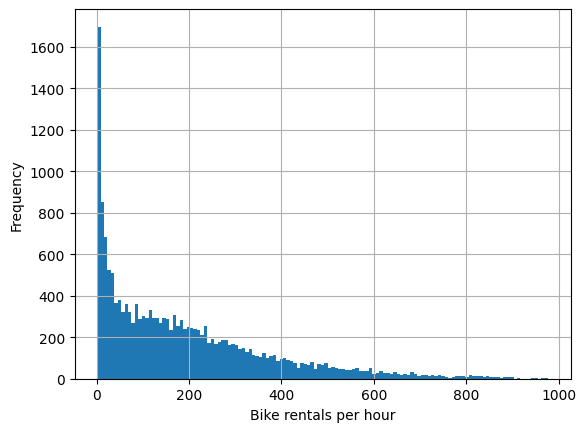

In [4]:
# square root of num datapoints for histogram bins
n_bins = int(np.sqrt(df.shape[0]))
print(f'Number of bins: {n_bins}')

# make histogram with n_bins and labels using df['cnt'].hist()
df['cnt'].hist(bins=n_bins)
plt.xlabel('Bike rentals per hour')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

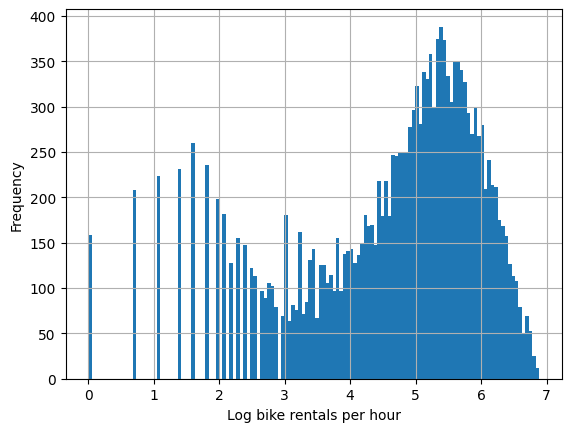

In [5]:
# apply logarithmic transformation to 'cnt' and plot histogram
df['log_cnt'] = np.log(df['cnt'])
df['log_cnt'].hist(bins=n_bins)
plt.xlabel('Log bike rentals per hour')
plt.ylabel('Frequency')

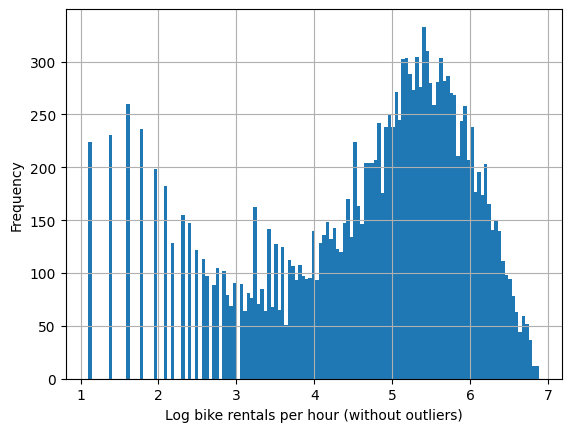

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe and 'cnt' is the column of interest.

# Step 1: Calculate Q1 and Q3
Q1 = df['log_cnt'].quantile(0.25)
Q3 = df['log_cnt'].quantile(0.75)

# Step 2: Calculate IQR
IQR = Q3 - Q1

# Step 3: Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Remove outliers
# Keep only the rows in the dataframe where 'log_cnt' falls within the bounds
df_filtered = df[(df['log_cnt'] >= lower_bound) & (df['log_cnt'] <= upper_bound)]

# Plotting the histogram of the log-transformed 'cnt' without outliers
df_filtered['log_cnt'].hist(bins=n_bins)
plt.xlabel('Log bike rentals per hour (without outliers)')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Summary statistics for the original 'cnt' column
original_stats = df['cnt'].describe()

# Summary statistics for the log-transformed 'cnt' column
log_transformed_stats = df['log_cnt'].describe()

# Assuming 'df_filtered' is the DataFrame after removing outliers from the 'log_cnt' column
# Summary statistics for the 'log_cnt' column after removing outliers
filtered_stats = df_filtered['log_cnt'].describe()

# Display the results
print("Original 'cnt' statistics:\n", original_stats)
print("\nLog-transformed 'cnt' statistics:\n", log_transformed_stats)
print("\nFiltered 'log_cnt' statistics:\n", filtered_stats)


Original 'cnt' statistics:
 count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Log-transformed 'cnt' statistics:
 count    17379.000000
mean         4.536082
std          1.486137
min          0.000000
25%          3.688879
50%          4.955827
75%          5.638355
max          6.884487
Name: log_cnt, dtype: float64

Filtered 'log_cnt' statistics:
 count    17013.000000
mean         4.625192
std          1.369859
min          1.098612
25%          3.806662
50%          4.990433
75%          5.648974
max          6.884487
Name: log_cnt, dtype: float64


### Above: Taking the log and filtering seems to lower the std


In [8]:
# convert season to catgorical using pd dummies
df = pd.get_dummies(df, columns=['season'],dtype=int)
# do same for df_filtered
df_filtered = pd.get_dummies(df_filtered, columns=['season'], dtype=int)

# print head of both
print(df.head())
print(df_filtered.head())


   instant      dteday  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01   0     1   0        0        6           0   
1        2  2011-01-01   0     1   1        0        6           0   
2        3  2011-01-01   0     1   2        0        6           0   
3        4  2011-01-01   0     1   3        0        6           0   
4        5  2011-01-01   0     1   4        0        6           0   

   weathersit  temp  ...   hum  windspeed  casual  registered  cnt   log_cnt  \
0           1  0.24  ...  0.81        0.0       3          13   16  2.772589   
1           1  0.22  ...  0.80        0.0       8          32   40  3.688879   
2           1  0.22  ...  0.80        0.0       5          27   32  3.465736   
3           1  0.24  ...  0.75        0.0       3          10   13  2.564949   
4           1  0.24  ...  0.75        0.0       0           1    1  0.000000   

   season_1  season_2  season_3  season_4  
0         1         0         0         0  
1         

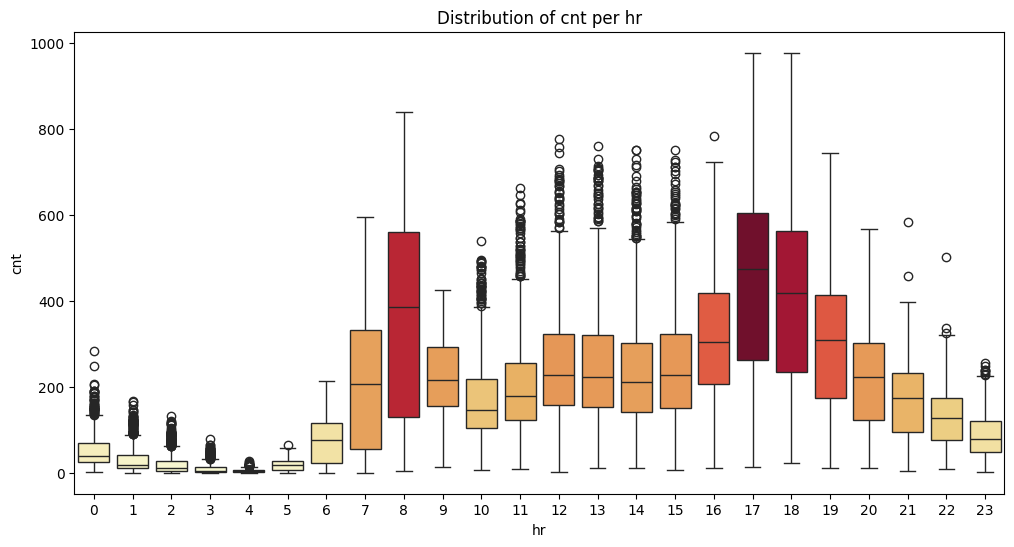

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_median_colored_boxplot(dataframe, x_column, y_column):
    # Calculate median for each category in x_column
    median_values = dataframe.groupby(x_column)[y_column].median()

    # Normalize the median values to get values between 0 and 1
    normalized_median = (median_values - median_values.min()) / (median_values.max() - median_values.min())

    # Create a colormap from red to white
    cmap = sns.color_palette("YlOrRd", as_cmap=True)

    # Map normalized median values to colors
    colors = normalized_median.map(cmap)

    # Create a list of colors for each category based on the sorted x_column
    sorted_categories = dataframe[x_column].sort_values().unique()
    color_list = [colors[category] for category in sorted_categories]

    # Create the boxplot
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(x=x_column, y=y_column, data=dataframe, palette=color_list)
    plt.title(f'Distribution of {y_column} per {x_column}')
    plt.show()

# Usage
plot_median_colored_boxplot(df, 'hr', 'cnt')


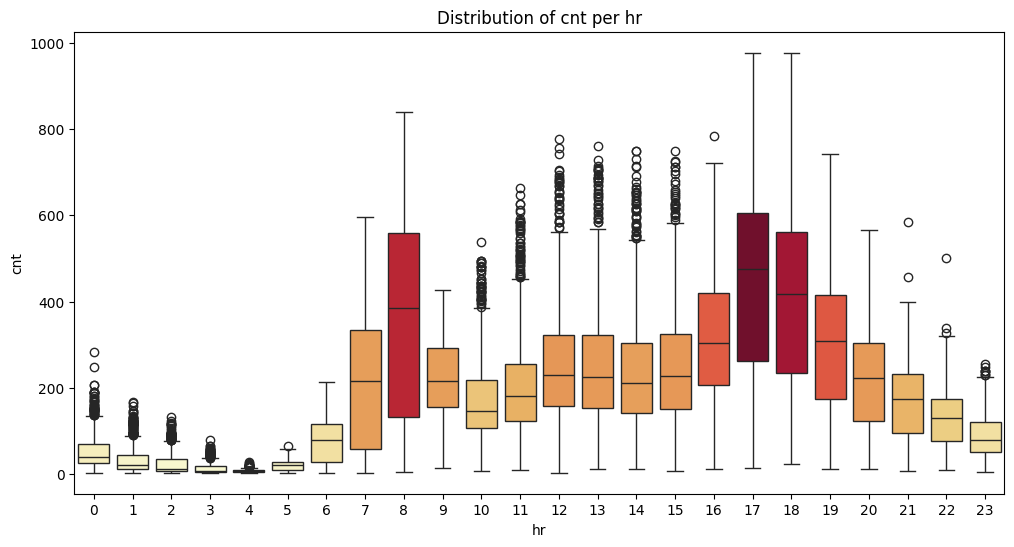

In [10]:
# for df_filtered
plot_median_colored_boxplot(df_filtered, 'hr', 'cnt')


### Histogram of logged and logged filtered (outliers) and box plots of df and df_filtered look similar
Thus filtering of the outliers will be determined after running cross-validation to compare impact of outliers on model performance.  

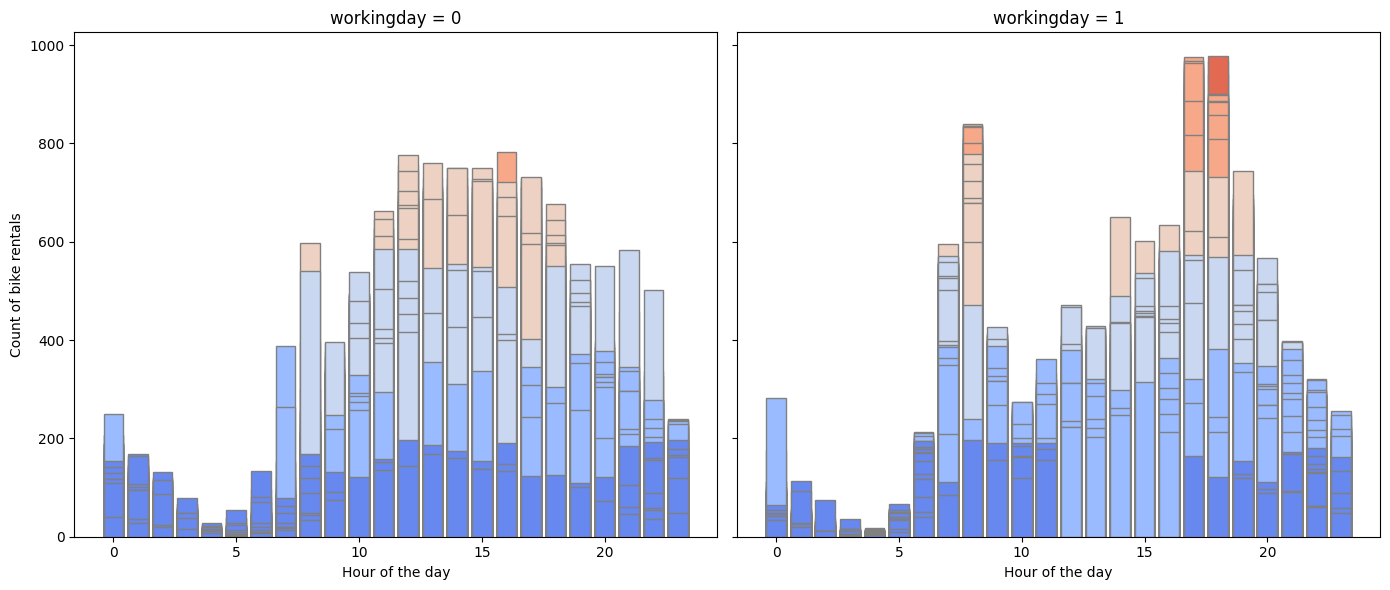

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'df' is your DataFrame and it has 'hr' and 'cnt' columns

# Normalize 'cnt' values between 0 and 1 for color mapping
cnt_max = df['cnt'].max()
cnt_min = df['cnt'].min()
df['cnt_normalized'] = (df['cnt'] - cnt_min) / (cnt_max - cnt_min)

# Define a color palette
palette = sns.color_palette("coolwarm", as_cmap=False)

# Define two empty subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Loop through each level of 'workingday' to create separate plots
for i, (ax, (workingday, group_data)) in enumerate(zip(axes, df.groupby('workingday'))):
    # Get colors from the palette based on the normalized 'cnt' values
    colors = group_data['cnt_normalized'].apply(lambda x: palette[int(x * (len(palette) - 1))])

    # Plot each bar individually
    ax.bar(group_data['hr'], group_data['cnt'], color=colors, edgecolor='grey')

    # Set the title for each subplot
    ax.set_title(f'workingday = {workingday}')
    ax.set_xlabel('Hour of the day')
    if i == 0:
        ax.set_ylabel('Count of bike rentals')

plt.tight_layout()
plt.show()


### the bar plots show that on working days there are spikes in usage during rush hours


In [12]:
# First, re-normalize the 'cnt' to get the 'cnt_normalized' column back
df['cnt_normalized'] = (df['cnt'] - cnt_min) / (cnt_max - cnt_min)

# Define the threshold for 'yellow or orange' colors
threshold = 0.75

# Find the hours where the normalized count is above the threshold
high_demand_hours = df[(df['cnt_normalized'] >= threshold) & (df['workingday'] == 1)]['hr'].unique()

# Optionally, remove the 'cnt_normalized' column again
df.drop('cnt_normalized', axis=1, inplace=True)

# Now let's print the hours that have 'yellow or orange' bars
print("Hours with high bike rentals (yellow/orange bars):", high_demand_hours)


Hours with high bike rentals (yellow/orange bars): [18 17  8 19]


### Rush hour, add new feature column
8 in the morning and 17 to 19 afternoon/evening 

In [13]:
# Define rush hour periods (assuming rush hours are at 8am, 5pm, 6pm, and 7pm)
df['rush_hour'] = df.apply(lambda row: 1 if (row['workingday'] == 1 and row['hr'] in [7,8,9, 17, 18, 19]) else 0, axis=1)
df.head().style.background_gradient(cmap='Greys')


,instant,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,season_1,season_2,season_3,season_4,rush_hour
0,1,2011-01-01,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16,2.772589,1,0,0,0,0
1,2,2011-01-01,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40,3.688879,1,0,0,0,0
2,3,2011-01-01,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32,3.465736,1,0,0,0,0
3,4,2011-01-01,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13,2.564949,1,0,0,0,0
4,5,2011-01-01,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1,0.000000,1,0,0,0,0


In [14]:
# drop 'instant column as it repeats the index
if 'instant' in df.columns.tolist(): 
    df.drop('instant', axis=1, inplace=True)
df.head().style.background_gradient(cmap='Greys')



,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,season_1,season_2,season_3,season_4,rush_hour
0,2011-01-01,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16,2.772589,1,0,0,0,0
1,2011-01-01,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40,3.688879,1,0,0,0,0
2,2011-01-01,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32,3.465736,1,0,0,0,0
3,2011-01-01,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13,2.564949,1,0,0,0,0
4,2011-01-01,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1,0.000000,1,0,0,0,0


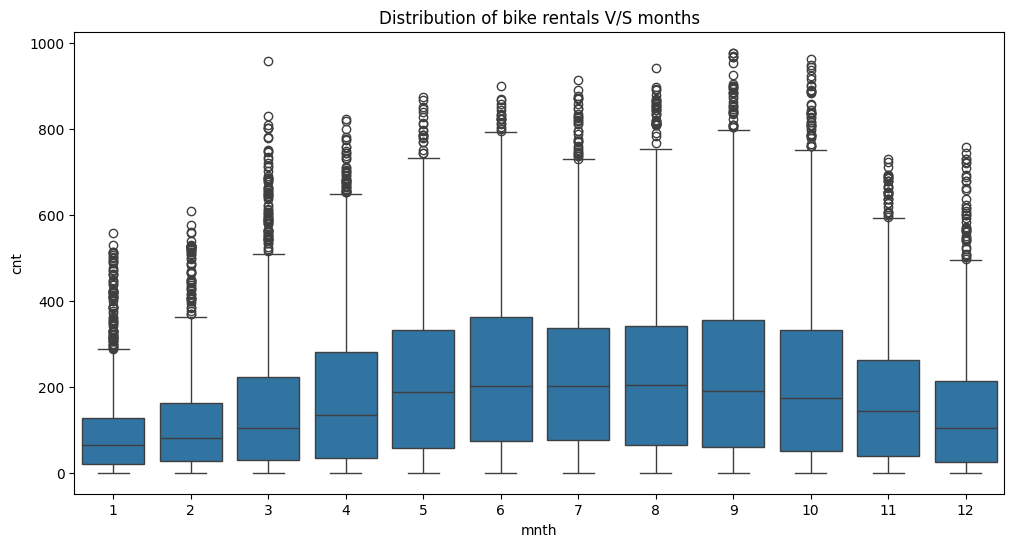

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x='mnth', y='cnt', data=df)
plt.title('Distribution of bike rentals V/S months')
plt.show()

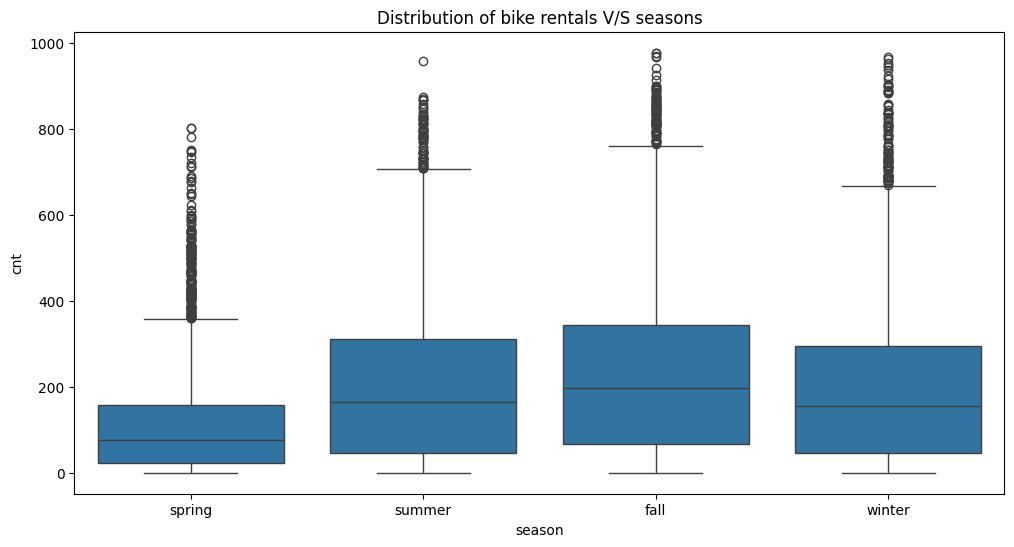

In [16]:
df['season'] = df[['season_1', 'season_2', 'season_3', 'season_4']].idxmax(axis=1)
df['season'] = df['season'].map({'season_1': 'spring', 'season_2': 'summer', 'season_3': 'fall', 'season_4': 'winter'})
plt.figure(figsize=(12,6))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Distribution of bike rentals V/S seasons')
plt.show()

Text(0.5, 1.0, 'Distribution of bike rentals V/S days of the week')

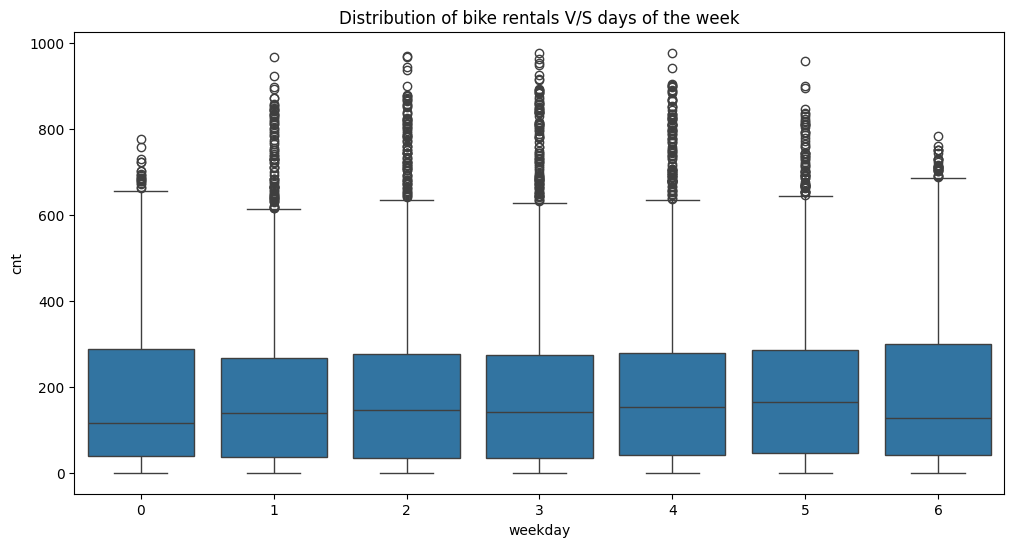

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title('Distribution of bike rentals V/S days of the week')

In [18]:
print(df.columns.tolist())
df.head().style.background_gradient(cmap='Greys')

['dteday', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour', 'season']


,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,season_1,season_2,season_3,season_4,rush_hour,season
0,2011-01-01,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16,2.772589,1,0,0,0,0,spring
1,2011-01-01,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40,3.688879,1,0,0,0,0,spring
2,2011-01-01,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32,3.465736,1,0,0,0,0,spring
3,2011-01-01,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13,2.564949,1,0,0,0,0,spring
4,2011-01-01,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1,0.000000,1,0,0,0,0,spring


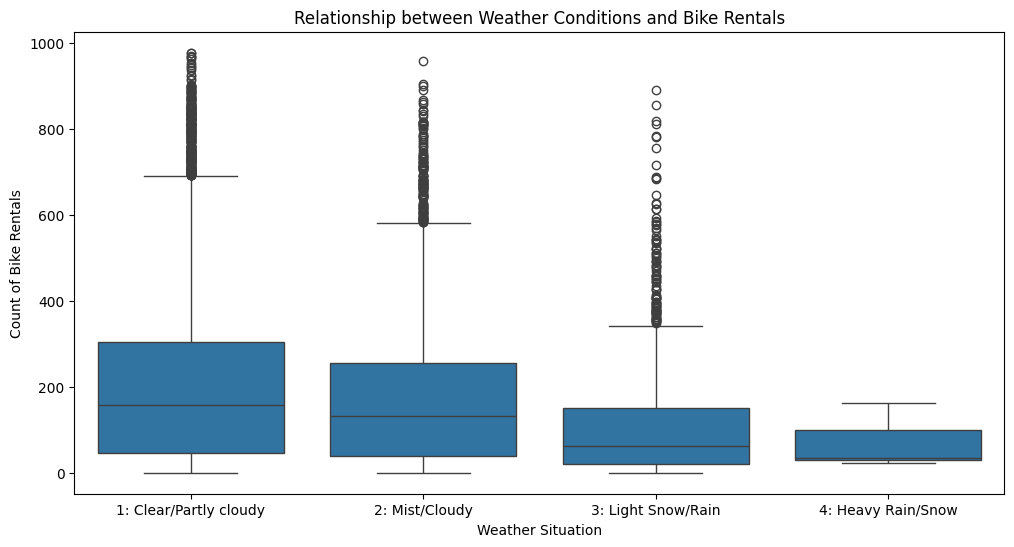

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains 'weathersit' and 'cnt' columns

plt.figure(figsize=(12, 6))
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Relationship between Weather Conditions and Bike Rentals')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Bike Rentals')
plt.xticks(ticks=[0, 1, 2, 3], labels=[
    '1: Clear/Partly cloudy',
    '2: Mist/Cloudy',
    '3: Light Snow/Rain',
    '4: Heavy Rain/Snow'
])
plt.show()


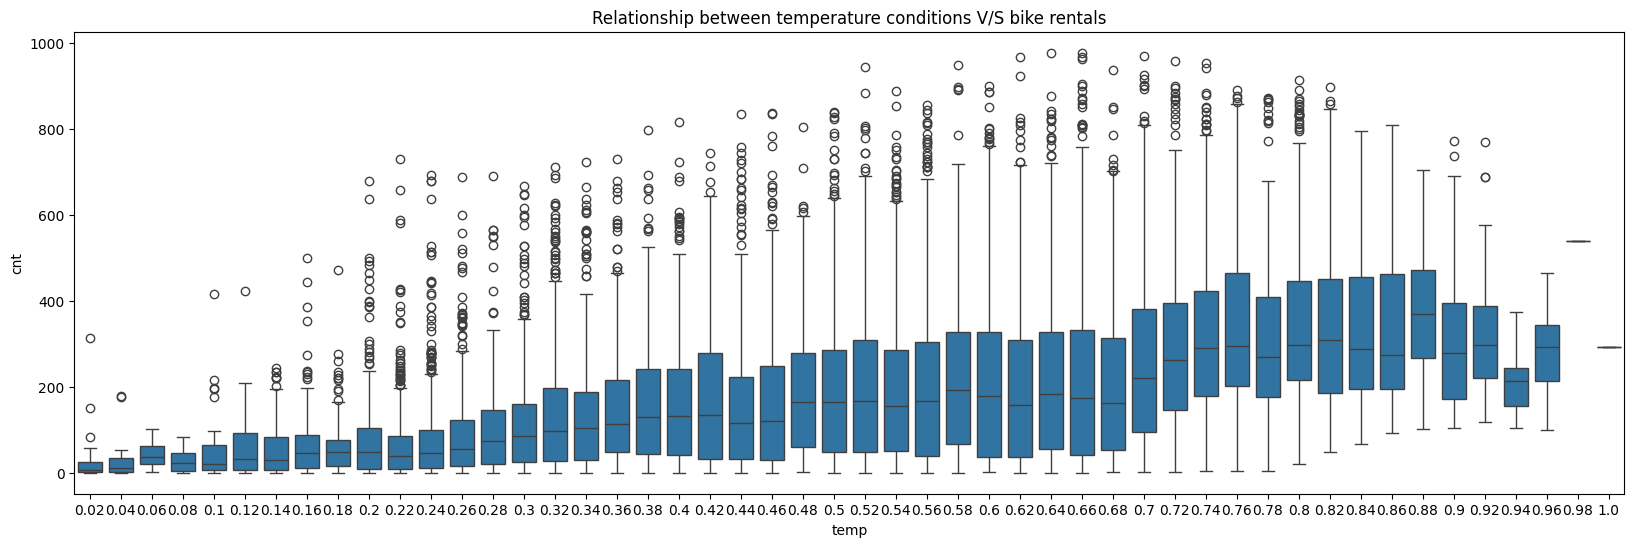

In [20]:
plt.figure(figsize=(20,6))
sns.boxplot(x='temp', y='cnt', data=df)
plt.title('Relationship between temperature conditions V/S bike rentals')
plt.show()

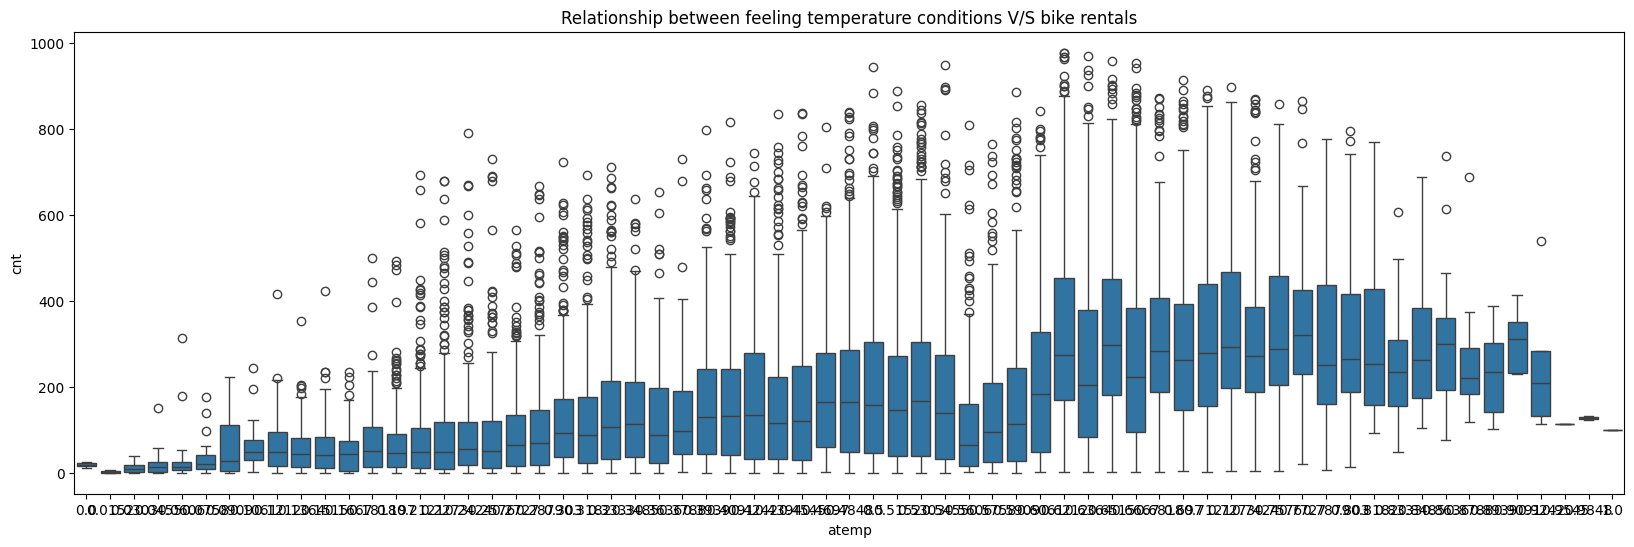

In [21]:
plt.figure(figsize=(20,6))
sns.boxplot(x='atemp', y='cnt', data=df)
plt.title('Relationship between feeling temperature conditions V/S bike rentals')
plt.show()

### Atemp or temp seems redundant


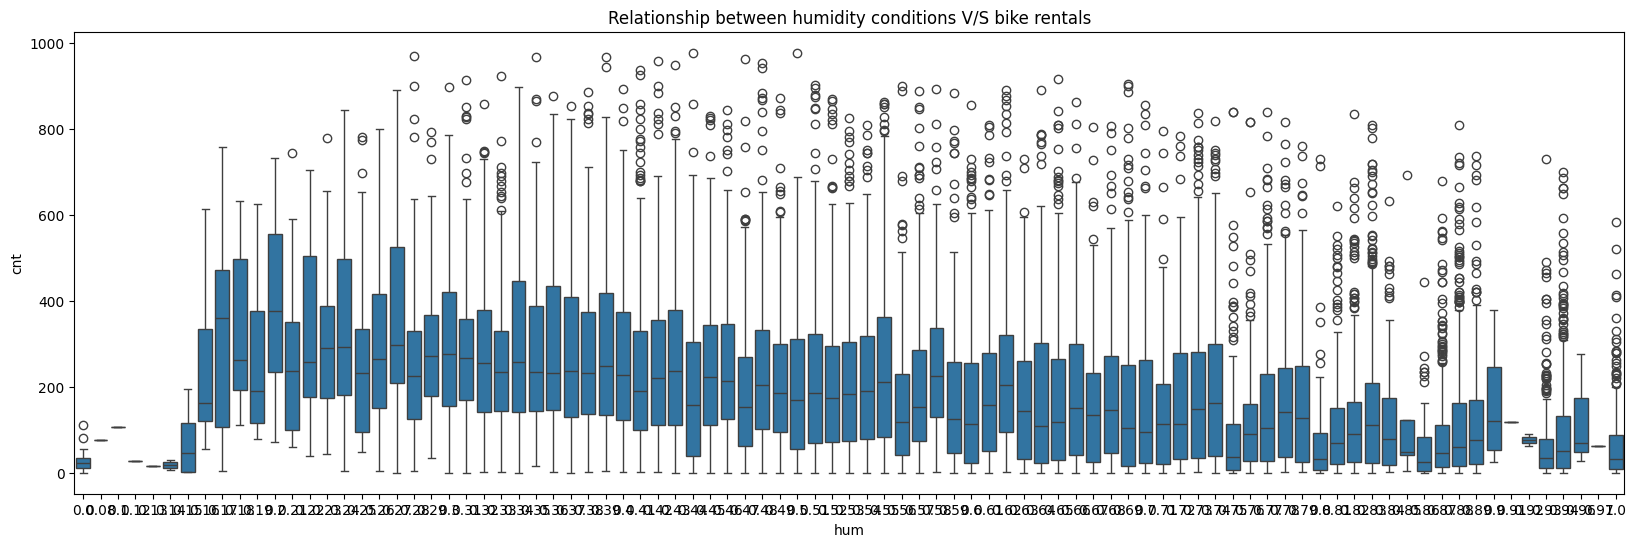

In [22]:
plt.figure(figsize=(20,6))
sns.boxplot(x='hum', y='cnt', data=df)
plt.title('Relationship between humidity conditions V/S bike rentals')
plt.show()

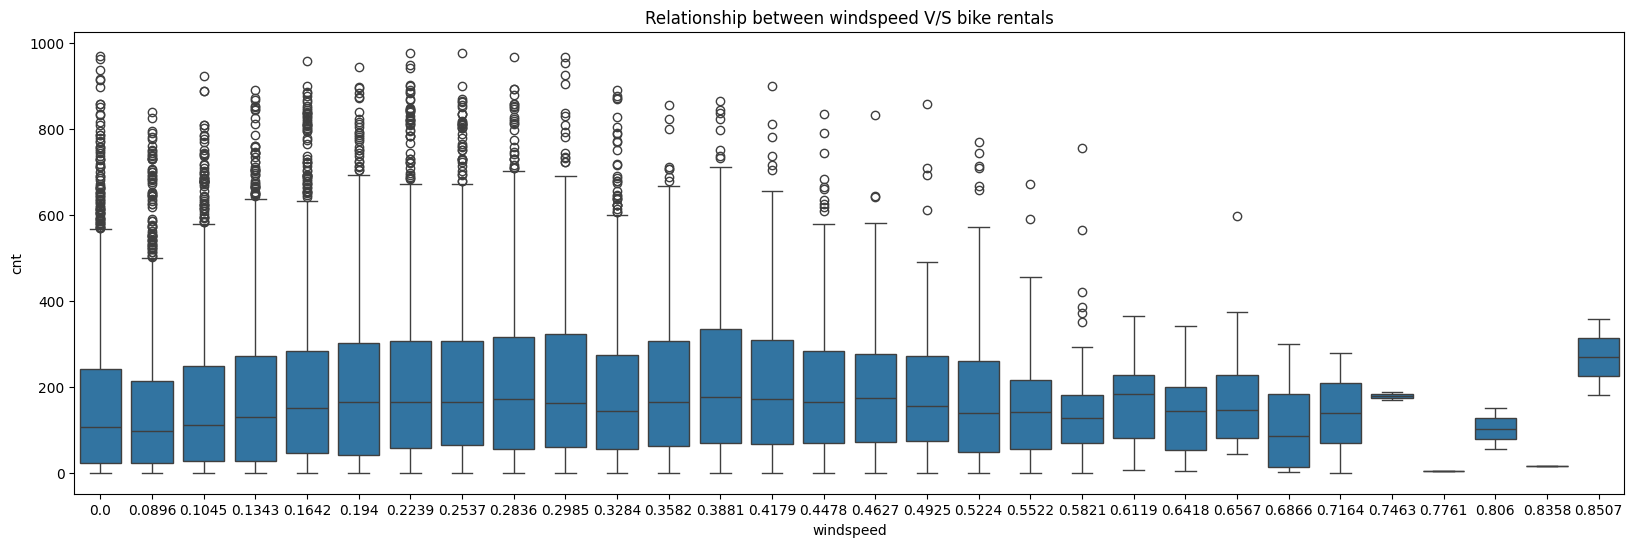

In [23]:
plt.figure(figsize=(20,6))
sns.boxplot(x='windspeed', y='cnt', data=df)
plt.title('Relationship between windspeed V/S bike rentals')
plt.show()

### drop cols we don't want

In [24]:
if 'season' in df.columns:
    df = df.drop('season', axis=1)
if 'dteday' in df.columns:
    df = df.drop('dteday', axis=1)
print(df.columns.tolist())

['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour']


In [25]:
df_filtered = df_filtered.drop(['dteday', 'instant', 'cnt'], axis=1)
df_filtered.columns.tolist()


['yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'log_cnt',
 'season_1',
 'season_2',
 'season_3',
 'season_4']

In [26]:
# drop casula and registered columns from both df and df_filtered
df = df.drop(['casual', 'registered'], axis=1)
df_filtered = df_filtered.drop(['casual', 'registered'], axis=1)
print(df.columns.tolist())
print(df_filtered.columns.tolist())

['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour']
['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4']


In [27]:
# drop log_cnt from df and add rush_hour to df_filtered
df = df.drop('log_cnt', axis=1)
df_filtered['rush_hour'] = df['rush_hour']
print(df.columns.tolist())
print(df_filtered.columns.tolist())


['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour']
['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour']


1. **Preventing Information Leakage**: When you scale the entire dataset before splitting it into training and testing sets (or before cross-validation), the scaling parameters (mean and standard deviation) are calculated using the entire dataset. This means that information from the test set (or validation set in cross-validation) is used to transform the training set, which is a form of data leakage.

2. **Proper Procedure in Cross-Validation**: In cross-validation, you should ensure that the scaling is done within each fold. This means:
    - For each fold in cross-validation, split the data into a training set and a validation set.
    - Compute the scaling parameters (mean and standard deviation for standard scaling) only on the training set.
    - Apply these scaling parameters to both the training set and the validation set.
    - Train the model on the scaled training set and evaluate it on the scaled validation set.
    - Repeat this process for each fold.

3. **Why This Matters**: This procedure ensures that the model is evaluated in a manner that's true to how it would perform on unseen data. It prevents the model from having prior knowledge about the test data distribution, which it wouldn't have in a real-world scenario.


In [28]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Drop the 'atemp' column
df = df.drop(columns=['atemp'])

# Define the columns to be scaled
scale_columns = ['temp', 'hum', 'cnt', 'windspeed']

# Initialize the scaler
#scaler = StandardScaler()

# Apply scaling
#df[scale_columns] = scaler.fit_transform(df[scale_columns])

# Convert categorical columns to dummy variables
categorical_columns = ['weathersit', 'mnth', 'hr', 'weekday']
df = pd.get_dummies(df, columns=categorical_columns, dtype=int)


In [29]:
# show head
df.head().style.background_gradient(cmap='Greys')

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,rush_hour,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0.240000,0.810000,0.000000,16,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0.220000,0.800000,0.000000,40,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.220000,0.800000,0.000000,32,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.240000,0.750000,0.000000,13,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0.240000,0.750000,0.000000,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
# Drop the 'atemp' column
df_filtered = df_filtered.drop(columns=['atemp'])

# Define the columns to be scaled (use 'log_cnt' instead of 'cnt')
#scale_columns_filtered = ['temp', 'hum', 'log_cnt', 'windspeed']

# Apply scaling
#df_filtered[scale_columns_filtered] = scaler.fit_transform(df_filtered[scale_columns_filtered])

# Convert categorical columns to dummy variables
df_filtered = pd.get_dummies(df_filtered, columns=categorical_columns, dtype=int)


In [31]:
df_filtered.head().style.background_gradient(cmap='Greys')

,yr,holiday,workingday,temp,hum,windspeed,log_cnt,season_1,season_2,season_3,season_4,rush_hour,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0.240000,0.810000,0.000000,2.772589,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0.220000,0.800000,0.000000,3.688879,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.220000,0.800000,0.000000,3.465736,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.240000,0.750000,0.000000,2.564949,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0.200000,0.860000,0.000000,1.098612,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Perform cross validation and then if things look okay do hold-out test set

In [37]:
# check the columns of df and df_filtered
print(df.columns.tolist())
print(df_filtered.columns.tolist())


['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'log_cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8

In [38]:
y = df['cnt']
print(y.head())

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Columns to scale
scale_columns_filtered = ['temp', 'hum', 'windspeed', 'log_cnt']

# Data preparation for df_filtered
X_filtered = df_filtered.drop(columns=['log_cnt'])
y_filtered = df_filtered['log_cnt']

# Define a column transformer for df_filtered
column_transformer_filtered = ColumnTransformer([
    ('scaler', StandardScaler(), scale_columns_filtered)
], remainder='passthrough')

# Define models with a pipeline for df_filtered
linear_pipeline_filtered = Pipeline([('transform', column_transformer_filtered), ('linear', LinearRegression())])
rf_pipeline_filtered = Pipeline([('transform', column_transformer_filtered), ('rf', RandomForestRegressor(n_estimators=100, random_state=42))])
gb_pipeline_filtered = Pipeline([('transform', column_transformer_filtered), ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))])

# Cross-validate models for df_filtered
for pipeline in [linear_pipeline_filtered, rf_pipeline_filtered, gb_pipeline_filtered]:
    scores = cross_val_score(pipeline, X_filtered, y_filtered, cv=5, scoring='neg_mean_squared_error')
    print(f"{pipeline.steps[-1][0]} Model Mean Cross-validation MSE:", np.mean(scores))


linear Model Mean Cross-validation MSE: -0.3191705942630662
rf Model Mean Cross-validation MSE: -0.20313413479278966
gb Model Mean Cross-validation MSE: -0.24878943534374684


In [39]:
# Columns to scale for df
scale_columns = ['temp', 'hum', 'windspeed']

# Data preparation for df
X = df.drop(columns=['cnt'])
y = df['cnt']

# Define a column transformer for df
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), scale_columns)
], remainder='passthrough')

# Define models with a pipeline for df
linear_pipeline_df = Pipeline([('transform', column_transformer), ('linear', LinearRegression())])
rf_pipeline_df = Pipeline([('transform', column_transformer), ('rf', RandomForestRegressor(n_estimators=100, random_state=42))])
gb_pipeline_df = Pipeline([('transform', column_transformer), ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))])

# Cross-validate models for df
for pipeline in [linear_pipeline_df, rf_pipeline_df, gb_pipeline_df]:
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"{pipeline.steps[-1][0]} Model Mean Cross-validation MSE:", np.mean(scores))


linear Model Mean Cross-validation MSE: -9302.892830921464
rf Model Mean Cross-validation MSE: -5687.740159446746
gb Model Mean Cross-validation MSE: -6903.616290689461


### try scaling 'cnt' to see if it improves MSE, can't use custom scaling from other notebook because of data leakage

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Function to scale data
def scale_data(df, quant_features):
    scaled_features = {}
    for feature in quant_features:
        mean, std = df[feature].mean(), df[feature].std()
        scaled_features[feature] = [mean, std]
        df[feature] = (df[feature] - mean) / std
    return df, scaled_features

# Define quantitative features
quant_features = ['cnt', 'temp', 'hum', 'windspeed']

# Copy the dataframe for scaling
df_scaled, scaling_params = scale_data(df.copy(), quant_features)

# Prepare features and target
X = df_scaled.drop(columns=['cnt'])
y = df_scaled['cnt']

# Initialize models
models = [LinearRegression(), RandomForestRegressor(n_estimators=100, random_state=42), GradientBoostingRegressor(n_estimators=100, random_state=42)]

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model in models:
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Calculate MSE
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
    
    print(f"{model.__class__.__name__} Mean CV MSE:", np.mean(mse_scores))


LinearRegression Mean CV MSE: 0.2346363707926558
RandomForestRegressor Mean CV MSE: 0.06842736198352402
GradientBoostingRegressor Mean CV MSE: 0.15311405917173476


The scores for `df_filtered` are negative due to the use of 'neg_mean_squared_error' as the scoring parameter in cross-validation. A higher value (closer to zero) is better in this context. For `df`, the scores are positive, and a lower value indicates better performance. To compare them effectively, we should consider the absolute values of these scores.

Here's the revised comparison:

| Model                       | df (Mean CV MSE)      | df_filtered (Mean CV MSE) | Better Performance |
|-----------------------------|-----------------------|---------------------------|--------------------|
| Linear Regression           | 0.2346                | -0.3192 (0.3192)          | df                 |
| Random Forest Regressor     | 0.0684                | -0.2031 (0.2031)          | df                 |
| Gradient Boosting Regressor | 0.1531                | -0.2488 (0.2488)          | df                 |

**Interpretation:**

- **Linear Regression:** The model performs better on the original dataset (`df`) since 0.2346 is lower than the absolute value of -0.3192.
- **Random Forest and Gradient Boosting Regressors:** Both models also show better performance on `df` as their MSEs (0.0684 and 0.1531, respectively) are lower than the absolute values of the MSEs for `df_filtered`.

**Conclusion and Decision for Hold-Out Testing:**

Based on this analysis, the preprocessing steps of logarithmic transformation and outlier filtering (`df_filtered`) do not seem to improve model performance for any of the models compared to using the original dataset (`df`). Therefore, it would be advisable to proceed with hold-out testing primarily on the original dataset (`df`). However, you could still perform hold-out testing on `df_filtered` to confirm these findings empirically.

### Now for hold out testing on df

In [55]:
# check columns for df only
print(df.columns.tolist())
# show head
df.head().style.background_gradient(cmap='Greys')

['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'rush_hour', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']


,yr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,rush_hour,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0.240000,0.810000,0.000000,16,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0.220000,0.800000,0.000000,40,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.220000,0.800000,0.000000,32,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.240000,0.750000,0.000000,13,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0.240000,0.750000,0.000000,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Training Score: 0.9902575187414667
Testing Score: 0.9347876096734236


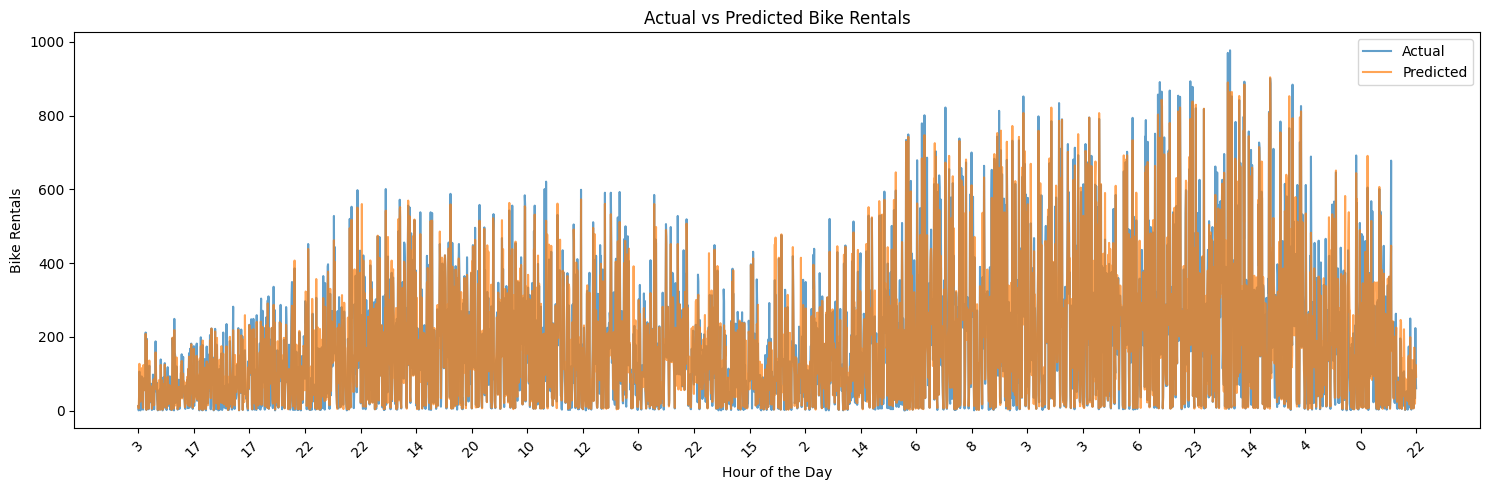

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Function to scale data (features only)
def scale_data(df_to_scale, quant_features):
    scaled_features = {}
    for feature in quant_features:
        mean, std = df_to_scale[feature].mean(), df_to_scale[feature].std()
        scaled_features[feature] = [mean, std]
        df_to_scale.loc[:, feature] = (df_to_scale.loc[:, feature] - mean) / std
    return df_to_scale, scaled_features

# Function to reverse scale data
def reverse_scale_data(scaled_data, scaled_features):
    for feature, (mean, std) in scaled_features.items():
        scaled_data.loc[:, feature] = scaled_data.loc[:, feature] * std + mean
    return scaled_data

# Define quantitative features (excluding 'cnt')
quant_features = ['temp', 'hum', 'windspeed']

# Load the dataset
df_original = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

# Splitting the data
X = df.drop(columns=['cnt'])
y = df['cnt']
dates = df_original['dteday']  # Assumes df and df_original are aligned
hours = df_original['hr']      # Assumes df and df_original are aligned
X_train, X_test, y_train, y_test, dates_train, dates_test, hours_train, hours_test = train_test_split(
    X, y, dates, hours, test_size=0.2, random_state=42
)

# Scale the training and testing data (features only)
X_train_scaled, scaling_params = scale_data(X_train.copy(), quant_features)
X_test_scaled, _ = scale_data(X_test.copy(), quant_features)

# Scale the target variable 'cnt' separately
mean_cnt, std_cnt = y_train.mean(), y_train.std()
y_train_scaled = (y_train - mean_cnt) / std_cnt
y_test_scaled = (y_test - mean_cnt) / std_cnt

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Evaluate the model
train_score = model.score(X_train_scaled, y_train_scaled)
test_score = model.score(X_test_scaled, y_test_scaled)
print(f"Training Score: {train_score}\nTesting Score: {test_score}")

# Perform predictions
predictions_scaled = model.predict(X_test_scaled)

# Reverse scale the predictions to the original scale
predictions = predictions_scaled * std_cnt + mean_cnt

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': predictions,
    'Date': dates_test.values,
    'Hour': hours_test.values
})

# Sort the plot_df by Date and Hour for chronological plotting
plot_df.sort_values(by=['Date', 'Hour'], inplace=True)

# Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(range(len(plot_df)), plot_df['Actual'], label='Actual', alpha=0.7)
plt.plot(range(len(plot_df)), plot_df['Predicted'], label='Predicted', alpha=0.7)
plt.xticks(ticks=np.linspace(0, len(plot_df), num=24), labels=plot_df['Hour'].iloc[np.linspace(0, len(plot_df) - 1, num=24).astype(int)], rotation=45)
plt.title('Actual vs Predicted Bike Rentals')
plt.xlabel('Hour of the Day')
plt.ylabel('Bike Rentals')
plt.legend()
plt.tight_layout()
plt.show()


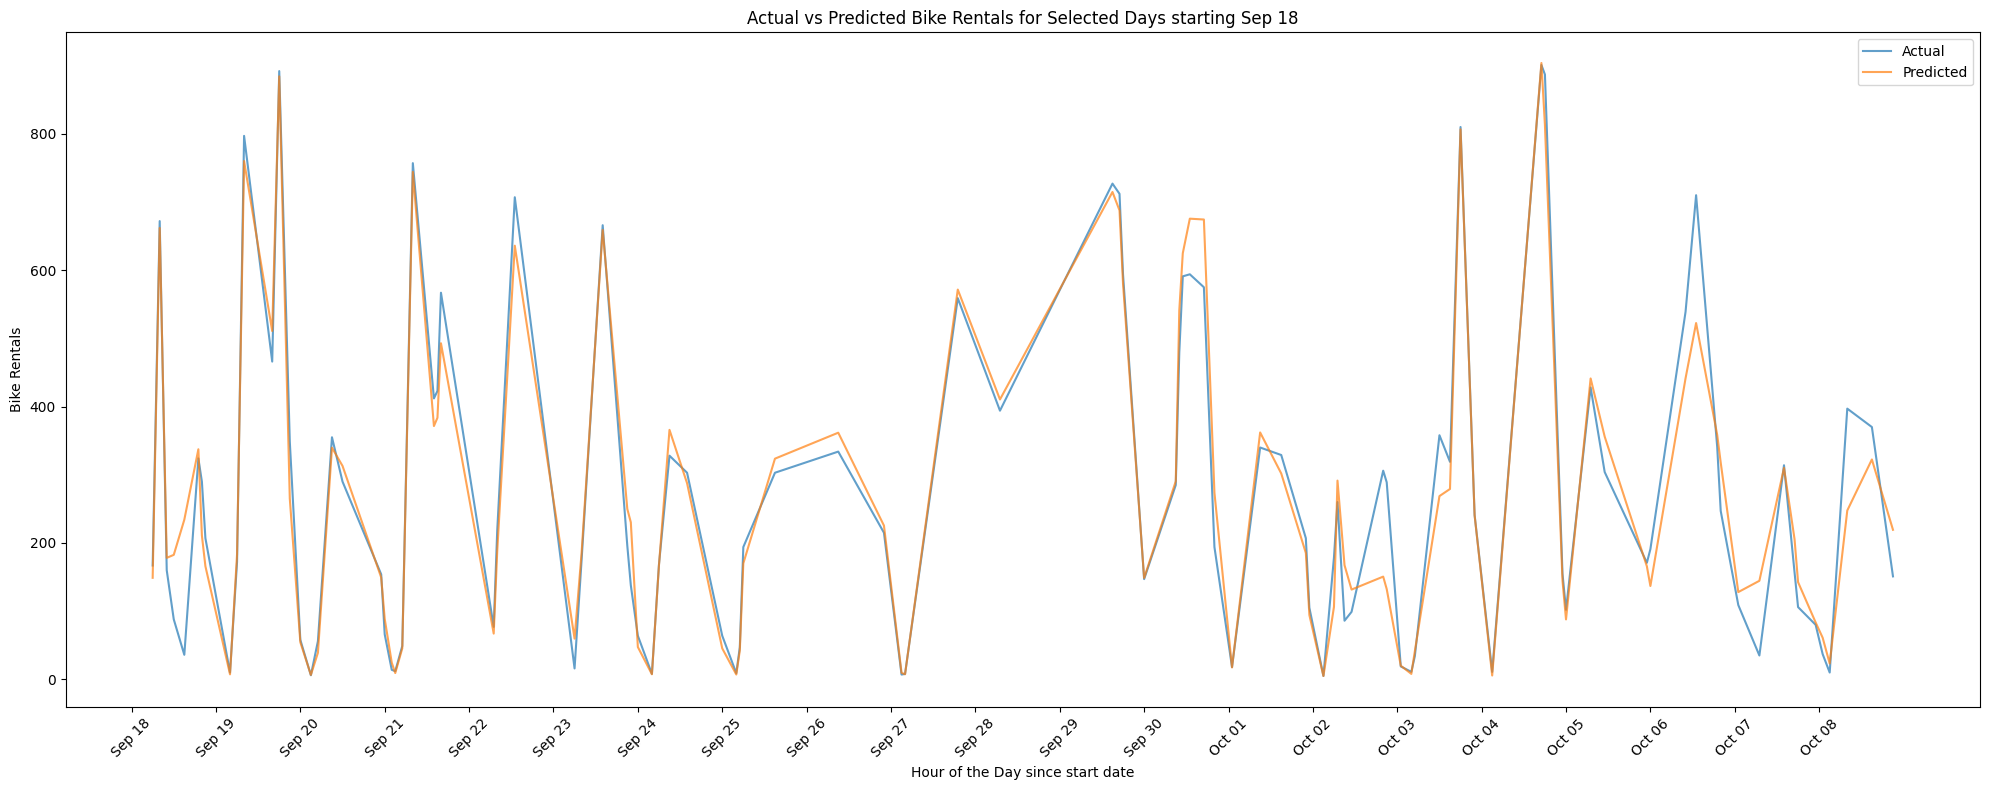

In [61]:
import random
# Convert 'Date' column to datetime
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

# Assuming 'Date' is in the format 'YYYY-MM-DD' and is sorted
unique_dates = plot_df['Date'].unique()
start_date_idx = random.randint(0, len(unique_dates) - 21)  # Ensure there's room for 21 days
start_date = unique_dates[start_date_idx]

# Get a mask for the selected range of dates
mask = (plot_df['Date'] >= start_date) & (plot_df['Date'] < unique_dates[start_date_idx + 21])
selected_plot_df = plot_df.loc[mask]

# Now, let's plot the selected range
plt.figure(figsize=(20, 8))
selected_days_hours = selected_plot_df['Hour'] + (selected_plot_df['Date'] - start_date).dt.days * 24
plt.plot(selected_days_hours, selected_plot_df['Actual'], label='Actual', alpha=0.7)
plt.plot(selected_days_hours, selected_plot_df['Predicted'], label='Predicted', alpha=0.7)

# Set up the x-axis labels to show the start date and hour
x_ticks = np.arange(0, 504, 24)  # One tick per day
x_labels = [(start_date + pd.Timedelta(days=i)).strftime('%b %d') for i in range(21)]  # One label per day

plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)
plt.title(f'Actual vs Predicted Bike Rentals for Selected Days starting {start_date.strftime("%b %d")}')
plt.xlabel('Hour of the Day since start date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.tight_layout()
plt.show()


# compare to deep learning, Keras

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming df is your full DataFrame and 'cnt' is the target variable
X = df.drop(columns=['cnt'])  # Features
y = df['cnt'].values.reshape(-1, 1)  # Target variable, reshaped as a 2D array for the scaler

# First split into training (80%) and temp (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the training temp into actual training (64%) and validation (16%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Convert scaled arrays to float32 for Keras
train_features_array = np.array(X_train_scaled).astype('float32')
val_features_array = np.array(X_val_scaled).astype('float32')
test_features_array = np.array(X_test_scaled).astype('float32')
train_targets_array = np.array(y_train_scaled).astype('float32')
val_targets_array = np.array(y_val_scaled).astype('float32')
test_targets_array = np.array(y_test_scaled).astype('float32')


Epoch 1/100


348/348 [==============================] - 1s 2ms/step - loss: 0.6307 - val_loss: 0.4179
Epoch 2/100
348/348 [==============================] - 0s 1ms/step - loss: 0.2450 - val_loss: 0.2385
Epoch 3/100
348/348 [==============================] - 0s 1ms/step - loss: 0.1557 - val_loss: 0.1468
Epoch 4/100
348/348 [==============================] - 0s 1ms/step - loss: 0.1141 - val_loss: 0.1108
Epoch 5/100
348/348 [==============================] - 0s 1ms/step - loss: 0.0960 - val_loss: 0.0960
Epoch 6/100
348/348 [==============================] - 0s 1ms/step - loss: 0.0883 - val_loss: 0.0883
Epoch 7/100
348/348 [==============================] - 0s 1ms/step - loss: 0.0821 - val_loss: 0.0841
Epoch 8/100
348/348 [==============================] - 0s 1ms/step - loss: 0.0783 - val_loss: 0.0823
Epoch 9/100
348/348 [==============================] - 0s 1ms/step - loss: 0.0749 - val_loss: 0.0781
Epoch 10/100
348/348 [==============================] - 0s 960us/step - loss: 0.0726 - val_loss: 0.0755

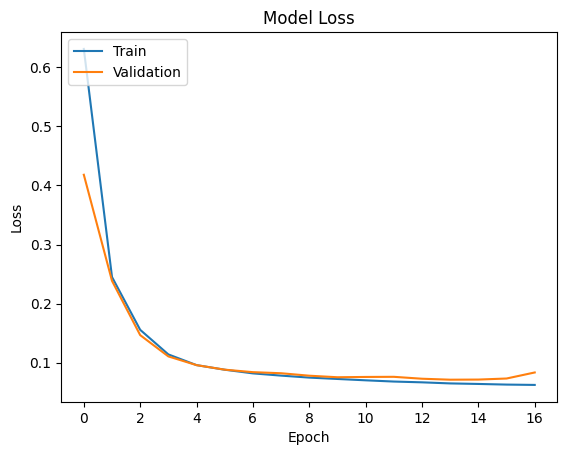

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the model architecture
model = Sequential()
model.add(Dense(32, input_dim=train_features_array.shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))

# Initialize the optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with validation data
history = model.fit(
    train_features_array,
    train_targets_array,
    epochs=100,
    batch_size=32,
    validation_data=(val_features_array, val_targets_array),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss = model.evaluate(test_features_array, test_targets_array)
print('Test loss:', loss)

# Plot the training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


  1/109 [..............................] - ETA: 5s

109/109 [==============================] - 0s 835us/step
MSE on the test set: 2746.030029296875


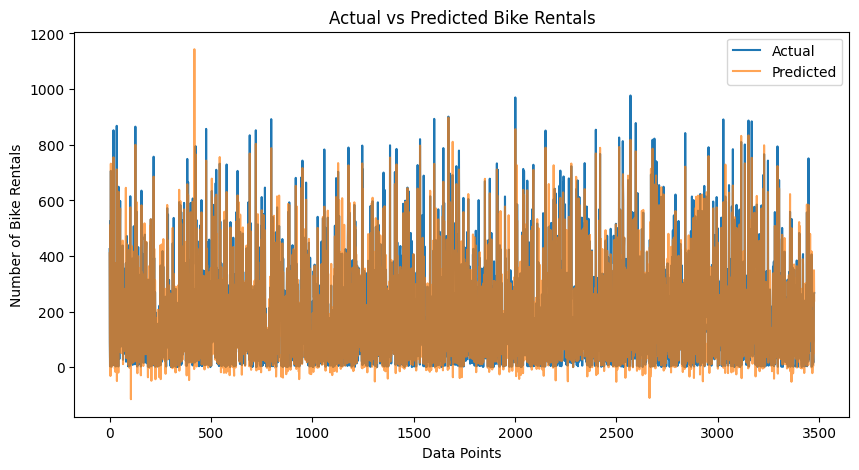

In [69]:
from sklearn.metrics import mean_squared_error

# Generate predictions for the test set
test_predictions_scaled = model.predict(test_features_array)

# If your data was scaled using StandardScaler or similar, inverse transform the predictions and the test targets
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
test_actual = scaler_y.inverse_transform(test_targets_array)

# Calculate MSE for the unscaled predictions
mse = mean_squared_error(test_actual, test_predictions)
print(f"MSE on the test set: {mse}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_actual, label='Actual')
plt.plot(test_predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Bike Rentals')
plt.xlabel('Data Points')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.show()


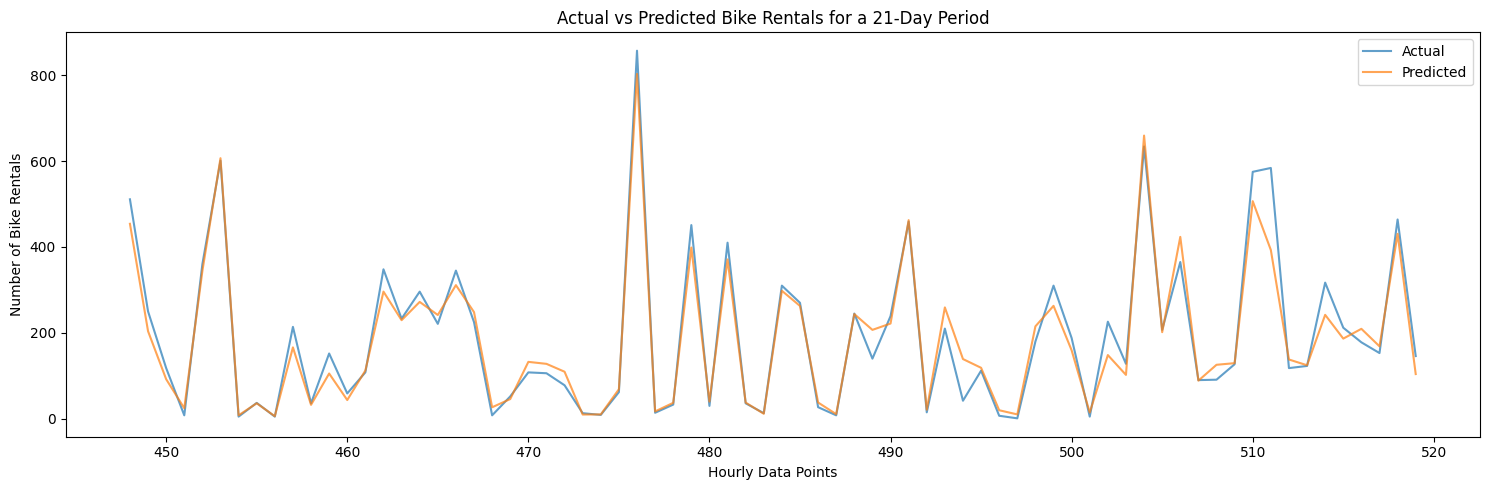

In [77]:
# Assuming `predictions` and `actual` are your full prediction and actual arrays
# Choose a random starting point for the 21-day sequence
start_index = np.random.randint(0, len(predictions) - (21 * 24))

# Select the range for 21 days
end_index = start_index + (3 * 24)
sampled_predictions = predictions[start_index:end_index]
sampled_actual = test_actual[start_index:end_index]

# Now create the plot for the sampled data
plt.figure(figsize=(15, 5))
plt.plot(range(start_index, end_index), sampled_actual, label='Actual', alpha=0.7)
plt.plot(range(start_index, end_index), sampled_predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Bike Rentals for a 21-Day Period')
plt.xlabel('Hourly Data Points')
plt.ylabel('Number of Bike Rentals')
plt.legend()
plt.tight_layout()
plt.show()
